## Energy calibration

In [1]:
#include <iostream>
#include <map>

using namespace std;

In [2]:
//get data from 335 file
TFile *ipf = new TFile("~/data/cali00335.root");
TTree *tree = (TTree*)ipf->Get("tree");
TCanvas *c1=new TCanvas("c1","c1");
Double_t e;
ULong64_t ts;
Int_t fr,str,det;
tree->SetBranchAddress("e",&e);
tree->SetBranchAddress("ts",&ts);
tree->SetBranchAddress("fr",&fr);
tree->SetBranchAddress("str",&str);
tree->SetBranchAddress("det",&det);
tree->Print();

******************************************************************************
*Tree    :tree      : tree                                                   *
*Entries :   690749 : Total =        19397029 bytes  File  Size =    5492309 *
*        :          : Tree compression factor =   3.53                       *
******************************************************************************
*Br    0 :e         : e/D                                                    *
*Entries :   690749 : Total  Size=    5541601 bytes  File Size  =    1993333 *
*Baskets :      174 : Basket Size=      32000 bytes  Compression=   2.78     *
*............................................................................*
*Br    1 :ts        : ts/l                                                   *
*Entries :   690749 : Total  Size=    5541779 bytes  File Size  =    3179230 *
*Baskets :      174 : Basket Size=      32000 bytes  Compression=   1.74     *
*...................................................

In [3]:
TFile *opf = new TFile("norm335.root","recreate");//output file
TTree *tr = new TTree("tree","tree");
Double_t xpar[128][3],ypar[48][3];
tr->Branch("e",&e,"e/D");
tr->Branch("ts",&ts,"ts/l");
tr->Branch("str",&str,"str/I");
tr->Branch("det",&det,"det/I");
tr->Branch("fr",&fr,"fr/I");

In [4]:
//read the parameters
ifstream in("fbnorm.txt");
Int_t ch;
Double_t xp,yp,zp;

In [5]:
while(1){
    in>>ch>>xp>>yp>>zp;
    if(!in.good()) break;
    if(ch<128) {
        xpar[ch][0]=xp;
        xpar[ch][1]=yp;
        xpar[ch][2]=zp;
        cout<<ch<<" "<<xp<<" "<<yp<<" "<<zp<<endl;
    }
    else{
        ypar[ch][0]=xp;
        ypar[ch][1]=yp;
        ypar[ch][2]=zp;        
        cout<<ch<<" "<<xp<<" "<<yp<<" "<<zp<<endl;
    }
    
}

0 2.29881 0.917899 -2.03832e-07
1 3.16126 0.911864 -1.26747e-07
2 2.4341 0.912291 -2.00395e-07
3 2.01177 0.90818 -1.6125e-07
4 7.43186 0.925972 2.87218e-07
5 1.41026 0.918927 -3.14154e-07
6 4.20528 0.914695 4.04147e-08
7 -0.746931 0.918769 -3.48177e-07
8 1.36437 0.919556 -2.34289e-07
9 -0.49336 0.927838 -3.75002e-07
10 1.05649 0.917418 -1.6765e-07
11 1.40403 0.907038 -3.89818e-07
12 3.30252 0.908879 -1.22602e-07
13 2.94765 0.91629 -2.31136e-07
14 3.08637 0.911849 1.44572e-07
15 5.15192 0.893442 -2.58417e-08
16 0.955283 0.89586 -1.1341e-07
17 2.95876 1.19546 -8.1845e-08
18 1.23908 1.23219 -3.81144e-07
19 3.82172 1.21755 9.89828e-08
20 1.31837 1.21353 -3.56752e-07
21 4.58697 1.22661 3.09601e-07
22 2.51155 1.22807 -1.50467e-07
23 0.399821 1.20591 -9.39462e-07
24 2.90446 1.16044 9.32343e-08
25 6.16088 1.20215 6.77407e-07
26 1.71196 1.21903 -2.81041e-07
27 1.68197 1.21967 -4.42748e-07
28 3.59816 1.21683 -2.22836e-07
29 3.61847 1.22572 3.03388e-09
30 3.63764 1.20247 -1.83222e-07
31 0.580286 

In [6]:
for(Int_t i=0;i<tree->GetEntriesFast();i++){
    tree->GetEntry(i);
    if(det==4) continue;
    if(det==2&&fr==2) e=xpar[str][0]+xpar[str][1]*e+xpar[str][2]*e*e;
    if(det==2&&fr==1) e=ypar[str][0]+ypar[str][1]*e+ypar[str][2]*e*e;
    tr->Fill();
    if(i%10000==0) cout<<"*";
}
tr->Write();
opf->Close();

**********************************************************************

## inspecting the normalized results

In [7]:
//get data from norm335.root file
ipf = new TFile("./norm335.root");
tree = (TTree*)ipf->Get("tree");
tree->SetBranchAddress("e",&e);
tree->SetBranchAddress("ts",&ts);
tree->SetBranchAddress("fr",&fr);
tree->SetBranchAddress("str",&str);
tree->SetBranchAddress("det",&det);
tree->Print();

******************************************************************************
*Tree    :tree      : tree                                                   *
*Entries :   690749 : Total =        19397029 bytes  File  Size =    5885268 *
*        :          : Tree compression factor =   3.30                       *
******************************************************************************
*Br    0 :e         : e/D                                                    *
*Entries :   690749 : Total  Size=    5541601 bytes  File Size  =    2386344 *
*Baskets :      174 : Basket Size=      32000 bytes  Compression=   2.32     *
*............................................................................*
*Br    1 :ts        : ts/l                                                   *
*Entries :   690749 : Total  Size=    5541779 bytes  File Size  =    3179230 *
*Baskets :      174 : Basket Size=      32000 bytes  Compression=   1.74     *
*...................................................

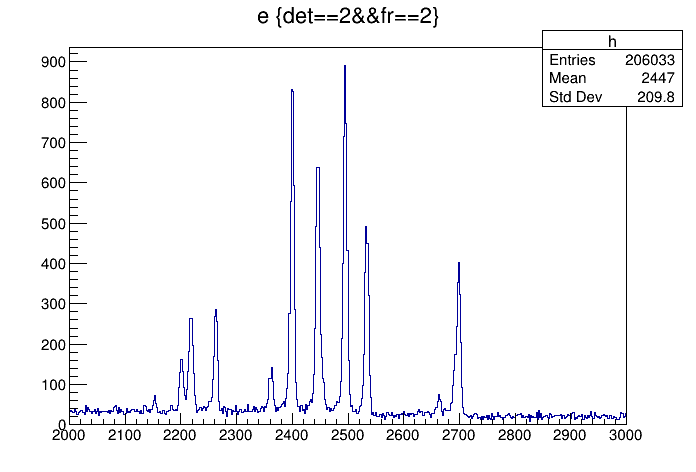

In [8]:
tree->Draw("e>>h(500,2000,3000)","det==2&&fr==2");
c1->Draw();

## find peaks and calibration

In [9]:
//output variable
TH1F *h=NULL,*hb=NULL;
Int_t nfound;
Double_t *xpeaks=NULL, *ypeaks=NULL;
TSpectrum *s=NULL;

In [10]:
void peaks(TString hname, Double_t thres=0.35,int backsub=1)
{
  h=(TH1F*)gROOT->FindObject(hname);
  if(!s) s=new TSpectrum(500);
  if(backsub) {
    hb=(TH1F*)s->Background(h,80,"same");
    h->Add(h,hb,1,-1);   
  }
  nfound=s->Search(h,2,"",thres); 
  TPolyMarker *pm=(TPolyMarker *)
    h->GetListOfFunctions()->FindObject("TPolyMarker");
  pm->SetMarkerStyle(32);
  pm->SetMarkerColor(kRed);
  pm->SetMarkerSize(0.4);
  xpeaks=s->GetPositionX();
  ypeaks=s->GetPositionY();
  for(int j=0;j<nfound;j++) {
    stringstream ss;
    ss<<xpeaks[j];
    TString s1=ss.str();
    TLatex *tex=new TLatex(xpeaks[j],ypeaks[j],s1);
    cout<<j+1<<"  "<<xpeaks[j]<<endl;
    tex->SetTextFont(13);
    tex->SetTextSize(14);
    tex->SetTextAlign(12);
    tex->SetTextAngle(90);
    tex->SetTextColor(kRed);
    tex->Draw();
  }
}

In [11]:
peaks("h");

1  2495
2  2401
3  2445
4  2533
5  2699


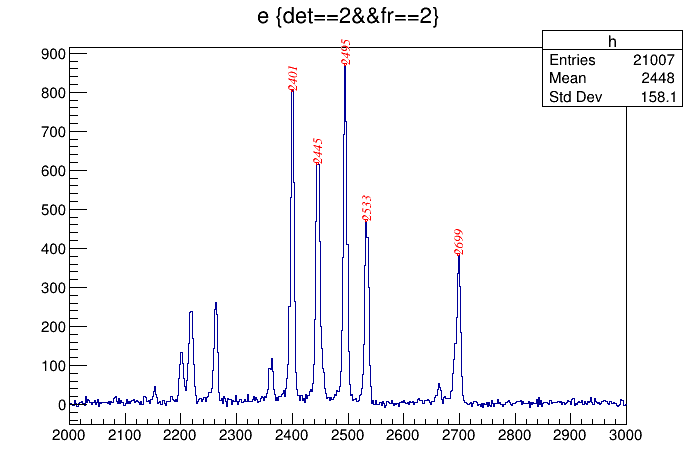

In [12]:
c1->Draw();

In [13]:
double xx[5];
double par[15];
Double_t epeaks[5]={6909,6646,6767,7016,7477};
TF1 *fg=new TF1("fg","gaus");
TF1 *fg3=new TF1("fg3","gaus(0)+gaus(3)+gaus(6)+gaus(9)+gaus(12)+gaus(15)",xpeaks[1]-10,xpeaks[4]+10);

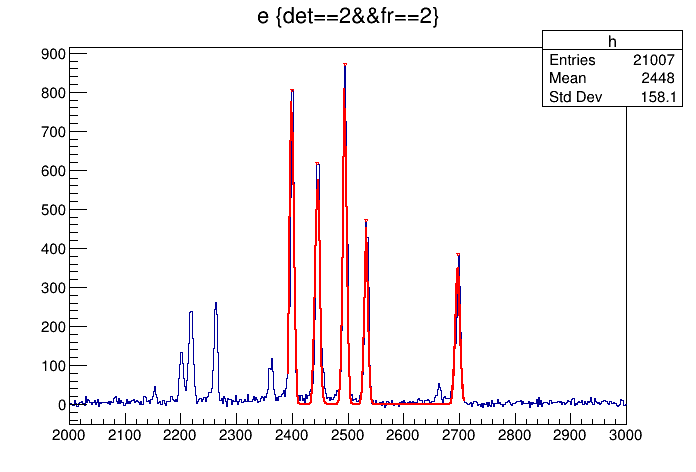

1  2494.88  2495
2  2399.99  2401
3  2446.02  2445
4  2533.49  2533
5  2697.89  2699


In [14]:
//fit the peaks using gaus function
c1->Clear();
for(int i=0;i<5;i++) {
    fg->SetParameters(ypeaks[i],xpeaks[i],5);//constant, mean, sigma
    h->Fit(fg,"Q","",xpeaks[i]-10,xpeaks[i]+10);
    xx[i]=fg->GetParameter(1);
    fg->GetParameters(&par[i*3]);
    cout<<i+1<<"  "<<xx[i]<<"  "<<xpeaks[i]<<endl;
}
fg3->SetParameters(par);
fg3->Draw("same");
c1->Draw();

In [15]:
TGraph *gp=new TGraph;
TF1 *fp=new TF1("fp","pol1");
Double_t fpar[2];
TH1F *hsum = new TH1F("hsum","back side spectrum",500,6000,8000);

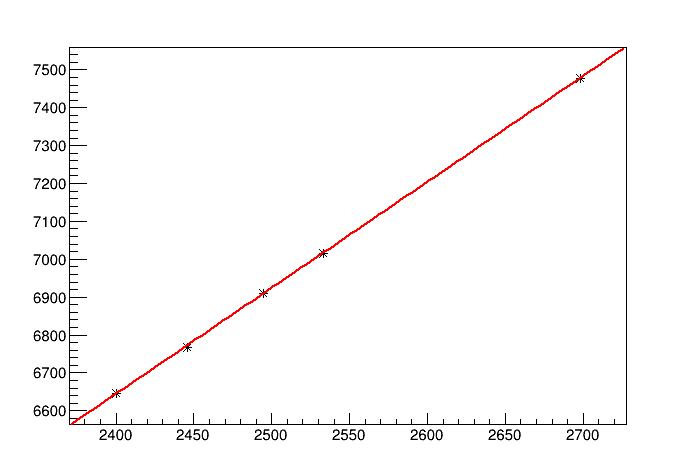


****************************************
Minimizer is Linear
Chi2                      =      32.2455
NDf                       =            3
p0                        =     -75.0199   +/-   36.1185     
p1                        =      2.79903   +/-   0.0143525   


In [16]:
for(int i=0;i<5;i++)
    gp->SetPoint(i,xx[i],epeaks[i]);
gp->Fit(fp);
fp->GetParameters(&fpar[0]);
gp->Draw("AP*");
c1->Draw();

In [17]:
opf = new TFile("cali335.root","recreate");//output file
tr = new TTree("tree","tree");
tr->Branch("e",&e,"e/D");
tr->Branch("ts",&ts,"ts/l");
tr->Branch("str",&str,"str/I");
tr->Branch("det",&det,"det/I");
tr->Branch("fr",&fr,"fr/I");

In [18]:
for(Int_t i=0;i<tree->GetEntriesFast();i++){
    tree->GetEntry(i);
    if(det==4) continue;
    e=fpar[0]+fpar[1]*e;
    tr->Fill();
    if(i%10000==0) cout<<"*";
    if(det==2&&fr==2)hsum->Fill(e);
}
tr->Write();
opf->Close();

**********************************************************************

## calibrated spectrum

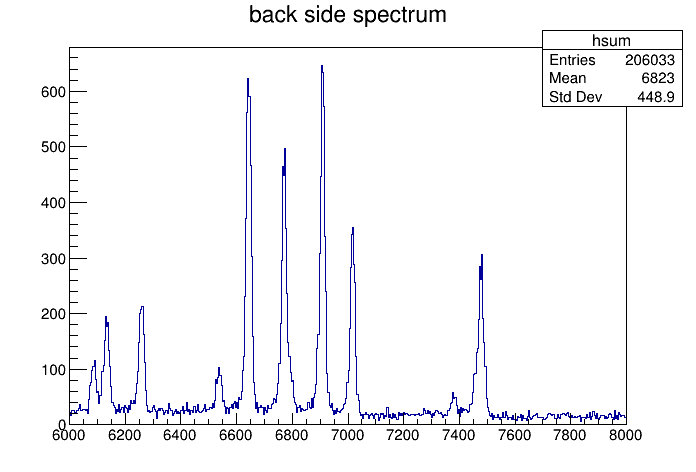

In [20]:
hsum->Draw();
c1->Draw();